
 ## nucleoid_occupancy_palm.ipynb
 Copyright © 2023-2025 Xiaofeng Dai (xiaofend@umich.edu)
 SPDX-License-Identifier: GPL-3.0-or-later

 This program is free software: you can redistribute it and/or modify
 it under the terms of the GNU General Public License as published by
 the Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 This program is distributed in the hope that it will be useful,
 but WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 GNU General Public License for more details.

 You should have received a copy of the GNU General Public License
 along with this program (LICENSE file in the repository root).
 If not, see <https://www.gnu.org/licenses/>.


### Estimate nucleoid occupancy using PALM reconstructions.

#### Workfolow
1. **File selection** – User selects a directory; the script
   gathers phase contrast images, localization `.fits.mat` files, and corresponding
   `PhaseMask.mat` masks.
2. **Per‑cell demo**
   * Build PALM super‑resolution image by applying Gaussian kernal on
     localization.
   * Fit a two‑component Gaussian mixture to the intensity
     histogram (outliers removed) and choose a threshold.
   * Segment nucleoid (pixels > threshold) and compute its area in high‑
     resolution pixels; compute total cell area from binary mask.
   * Store nucleoid‑to‑cell area ratio for later statistics.
3. **Batch processing** – Iterate through all files, accumulate per‑cell
   ratios in `store_nuc_ratio`, and plot a histogram.

Packages

In [1]:
# import modules
import sys
import numpy as np
import glob
import tifffile as tif

import pandas as pd
import matplotlib.pyplot as plt
from skimage import filters
from scipy.interpolate import interpn
import h5py
from tqdm import tqdm
import scipy.io

import tkinter as tk
from tkinter import filedialog
import os

Functions

In [2]:
def get_all_files_in_folder(initial_path=None):
    # Create a hidden Tkinter root window
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    # Let the user select a folder
    # folder_path = filedialog.askdirectory(title="Select a Folder")
    folder_path = filedialog.askdirectory(title="Select a Folder", initialdir=initial_path)

    # Destroy the Tkinter root window
    root.destroy()

    # If no folder is selected, return an empty list
    if not folder_path:
        print("No folder selected.")
        return []

    # Get all file names in the selected folder
    try:
        file_names = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return file_names
    except Exception as e:
        print(f"Error while accessing the folder: {e}")
        return []

def gaussian_2d(x, y, x0, y0, sigma, A):
    return A*np.exp(-((x-x0)**2 + (y-y0)**2) / (2 * sigma**2))  

def mat2df(file_path, variable_name='fits'):
    """
    Convert specified variable(s) from an HDF5-based .mat file (v7.3)
    into Pandas DataFrames. Handles both struct (Group) and array (Dataset).

    Parameters
    ----------
    file_path : str
        Path to the .mat file.
    variable_name : str or list of str
        Name or names of the variables to extract.
        If a single string, returns a DataFrame for that variable.
        If a list of strings, returns a dict of DataFrames keyed by variable name.

    Returns
    -------
    pd.DataFrame or dict[str, pd.DataFrame]
        A DataFrame (if one variable was requested) or a dictionary
        of DataFrames (if multiple variables were requested).
    """

    def _h5_to_df(obj, var_name):
        """
        Convert an HDF5 object (Group or Dataset) to a pd.DataFrame.
        If it's a Group, assume it's like a struct in MATLAB.
        If it's a Dataset, assume it's a numeric array.
        """
        if isinstance(obj, h5py.Group):
            # It's a MATLAB struct
            data_dict = {}
            for key in obj.keys():
                data_dict[key] = obj[key][:]
            # Flatten each field to 1D
            return pd.DataFrame({
                k: data_dict[k].flatten() for k in data_dict
            })

        elif isinstance(obj, h5py.Dataset):
            # It's a numeric array
            arr = obj[:]
            if arr.ndim == 1:
                # 1D array => single column
                return pd.DataFrame(arr, columns=[var_name])
            elif arr.ndim == 2:
                # 2D array => multiple columns
                nrows, ncols = arr.shape
                # Name columns something like varname_0, varname_1, etc.
                col_names = [f"{var_name}_{i}" for i in range(ncols)]
                return pd.DataFrame(arr, columns=col_names)
            else:
                # More than 2D? depends on your data, handle or raise error
                raise ValueError(f"Dataset {var_name} has {arr.ndim}D, "
                                 "which is not directly supported.")
        else:
            raise ValueError(f"Unsupported HDF5 object type for {var_name}: "
                             f"{type(obj)}")

    # Normalize input to a list so we can handle multiple or single variables
    if isinstance(variable_name, str):
        variable_name = [variable_name]

    results = {}
    with h5py.File(file_path, 'r') as f:
        for var_name in variable_name:
            if var_name not in f:
                raise KeyError(f"'{var_name}' not found in the file.")
            results[var_name] = _h5_to_df(f[var_name], var_name)

    # Return a single DataFrame if only one variable was requested
    if len(results) == 1:
        return list(results.values())[0]

    return results


def get_fits(df,track_df):
    cell_id  = []
    cols = []
    rows = []
    uncertainties = []
    
    for index, row in df.iterrows():
        
        goodfit = row['goodfit']
        uncertainty = row['widthcCI'] * pixsize
        if goodfit == 1 and uncertainty < .080:
            if len(track_df[track_df['molid']==row['molid']]['cellid'])==1:
                cell_id.append(track_df[track_df['molid']==row['molid']]['cellid'].values[0])                                                     
                cols.append(row['col'])
                rows.append(row['row'])
                uncertainties.append(row['widthcCI'])
            
    # print("mean uncertainty", np.mean(uncertainties)*pixsize)
    return[cell_id,cols,rows, uncertainties]



# def select_folder(initial_path=None):
#     # Create a hidden Tkinter root window
#     root = tk.Tk()
#     root.withdraw()  # Hide the main window

#     # Open a folder selection dialog starting from the given path
#     folder_path = filedialog.askdirectory(title="Select a Folder", initialdir=initial_path)

#     # Destroy the Tkinter root window
#     root.destroy()

#     # Return the selected folder path as a string (or None if no folder was selected)
#     return folder_path if folder_path else None

Set parameters and load Data

In [ ]:
# set global parameters
global pixsize, min_locs
pixsize = 0.049 # microns per pixel 
palm_pix_factor = 5
loc_pres = 0.60 # in pixels
saveplot = True
showplot = True

files = get_all_files_in_folder(initial_path=r"Example_Folder/subfolder/*")
# print(files)

phaseimg_files = [file for file in files if ".tif" in file and "PhaseMask" not in file]
fits_files = [file for file in files if "fits.mat" in file]
mask_files = [file for file in files if "PhaseMask.mat" in file]
      
fits_files.sort()
phaseimg_files.sort()


 Single cell PALM reconstruction (demo)

cell index # 1
number of localizations:  1462


PALM Reconstruction: 100%|██████████| 1462/1462 [00:11<00:00, 124.99it/s]


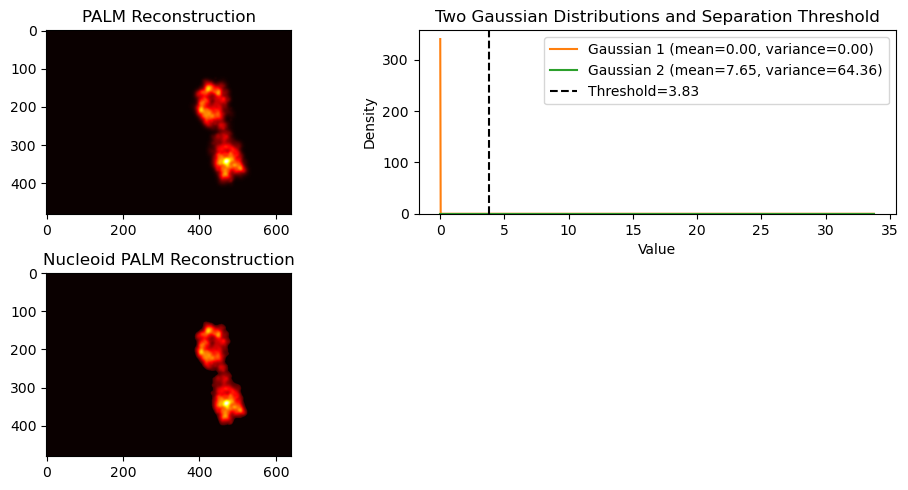

nucleoid size:  18916
cell size:  36900
nucleoid to cell ratio:  0.5126287262872629
---------------------------------------------


In [4]:
num=1

img = tif.imread(phaseimg_files[num]) # read phase image
numrows, numcols = img.shape # get dimensions of phase image
# plt.imshow(img, cmap = 'gray')

import scipy.io
# Load the .mat file
mat_data = scipy.io.loadmat(mask_files[num])
# Extract the 'PhaseMask' variable as a NumPy array
phase_mask_raw = mat_data['PhaseMask']
# plt.imshow(phase_mask_raw, cmap = 'gray')

# unique values in phase mask
unique, counts = np.unique(phase_mask_raw, return_counts=True)
# get index of value greater than 0 in unique
idx = np.where(unique > 0)
unique = unique[idx]
counts = counts[idx]
# print("unique values in phase mask: ", unique)
# print("counts of unique values in phase mask: ", counts)

fits_path = fits_files[num]
fits_single = mat2df(fits_path, 'fits')
track_single = mat2df(fits_path, 'tracks')
track_single = track_single.T
track_single.columns = ['frame','row','col','trackid','cellid','molid']

# pull localization coordinates
localizations = get_fits(fits_single, track_single)
locs_transpose_all = np.asarray(localizations).T

for ind_cell in unique:
    print('cell index #', ind_cell)
    phase_mask = phase_mask_raw.copy()
    phase_mask[phase_mask_raw != ind_cell] = 0
    # plt.imshow(phase_mask, cmap = 'gray')
    # plt.show()
    locs_transpose = locs_transpose_all[locs_transpose_all[:,0] == ind_cell]
    locs_transpose = locs_transpose[:,1:]

    # make grid with smaller pixel size
    yy, xx = np.mgrid[0:img.shape[0]*palm_pix_factor, 0:img.shape[1]*palm_pix_factor]

    # initiate palm image
    palm_reconstruction = np.zeros((img.shape[0]*palm_pix_factor,img.shape[1]*palm_pix_factor))
    print("number of localizations: ", len(locs_transpose))

    # use tqdm to show progress bar
    for loc in tqdm(locs_transpose[:],desc='PALM Reconstruction'):
        palm_reconstruction += gaussian_2d(xx, yy, loc[0]*palm_pix_factor, loc[1]*palm_pix_factor,
                                        sigma=loc[2]*palm_pix_factor, A= 1)


    # pixel intensity information
    test = np.array(palm_reconstruction)
    test = test.flatten()

    # plot PALM and histogram side by side
    plt.figure(figsize=(10,5))
    plt.subplot(2,2,1)
    plt.imshow(palm_reconstruction, cmap = 'hot')
    plt.title('PALM Reconstruction')

    from sklearn.mixture import GaussianMixture

    # get rid of outliers from test
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(test, 5)
    Q3 = np.percentile(test, 99.95)
    # IQR = Q3 - Q1
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 #- 1.5 * IQR
    upper_bound = Q3 #+ 1.5 * IQR
    # Filter out the outliers
    values = test[(test >= lower_bound) & (test <= upper_bound)]

    # # Load data (ensure 'values' is the array of your data)
    # values = test[test >= 0.005*np.max(test)].flatten()

    # Fit a Gaussian Mixture Model with 2 components
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(values.reshape(-1, 1))

    # Extract GMM parameters
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()
    weights = gmm.weights_.flatten()

    # Sort the means to identify the lower and higher Gaussian
    sorted_indices = np.argsort(means)
    mean1, mean2 = means[sorted_indices]
    variance1, variance2 = variances[sorted_indices]
    weight1, weight2 = weights[sorted_indices]

    # threshold = (mean1 + mean2) / 2
    threshold = mean2/ 2

    from scipy.stats import norm
    # Define the two Gaussian PDFs
    def gaussian_pdf(x, mean, variance, weight):
        return weight * norm.pdf(x, loc=mean, scale=np.sqrt(variance))

    # Generate x values and individual distributions
    x = np.linspace(min(values), max(values), 1000)
    pdf1 = gaussian_pdf(x, mean1, variance1, weight1)
    pdf2 = gaussian_pdf(x, mean2, variance2, weight2)

    # Plot the two Gaussian distributions and the threshold
    plt.subplot(2,2,2)
    plt.hist(values, bins=50, density=True, alpha=0.6)
    plt.plot(x, pdf1, label=f'Gaussian 1 (mean={mean1:.2f}, variance={variance1:.2f})')
    plt.plot(x, pdf2, label=f'Gaussian 2 (mean={mean2:.2f}, variance={variance2:.2f})')
    plt.axvline(threshold, color='black', linestyle='--', label=f'Threshold={threshold:.2f}')
    plt.title('Two Gaussian Distributions and Separation Threshold')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()

    # Apply the threshold to palm_reconstruction
    nuc_palm = palm_reconstruction.copy()
    nuc_palm[nuc_palm < threshold] = 0

    plt.subplot(2,2,3)
    plt.imshow(nuc_palm, cmap='hot')
    plt.title('Nucleoid PALM Reconstruction')
    plt.tight_layout()  # This avoids overlapping between subplots
    plt.show()

    # num of pixils in nuc_palm greater than 0
    nuc_size = np.sum(nuc_palm > 0)
    print("nucleoid size: ", nuc_size)


    # num of pixils in phase_mask greater than 0
    cell_size = np.sum(phase_mask > 0)*palm_pix_factor*palm_pix_factor
    print("cell size: ", cell_size)

    # calculate nucleoid to cell ratio
    nuc_ratio = nuc_size/cell_size
    print("nucleoid to cell ratio: ", nuc_ratio)
    print('---------------------------------------------')
    


Batch processing

100%|██████████| 63/63 [22:12<00:00, 21.15s/it]


(array([ 1.,  0.,  2.,  2.,  2.,  4.,  4.,  9., 11.,  8.,  3.,  8.,  7.,
         1.,  2.,  0.,  1.,  1.,  0.,  1.]),
 array([0.44094545, 0.45308246, 0.46521946, 0.47735647, 0.48949347,
        0.50163047, 0.51376748, 0.52590448, 0.53804148, 0.55017849,
        0.56231549, 0.5744525 , 0.5865895 , 0.5987265 , 0.61086351,
        0.62300051, 0.63513751, 0.64727452, 0.65941152, 0.67154852,
        0.68368553]),
 <BarContainer object of 20 artists>)

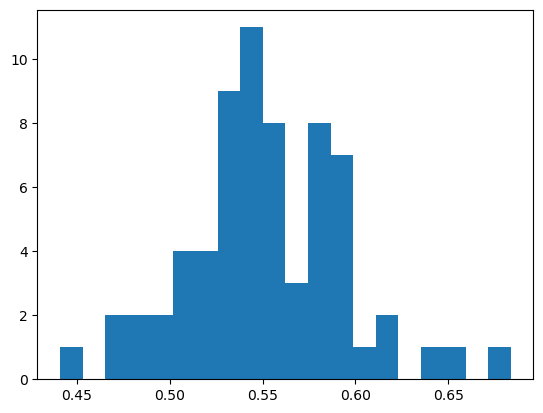

In [5]:
from sklearn.mixture import GaussianMixture
# from scipy.stats import norm
# # Define the two Gaussian PDFs
# def gaussian_pdf(x, mean, variance, weight):
#     return weight * norm.pdf(x, loc=mean, scale=np.sqrt(variance))

# number of experiments
num_exp = len(phaseimg_files)
# loop through all files
# store_nuc_ratio = np.zeros(num_exp)
store_nuc_ratio = []
store_cell_size = []
store_nuc_size = []
for num in tqdm(range(num_exp)):
    img = tif.imread(phaseimg_files[num]) # read phase image
    numrows, numcols = img.shape # get dimensions of phase image
    # plt.imshow(img, cmap = 'gray')

    # Load the .mat file
    mat_data = scipy.io.loadmat(mask_files[num])
    # Extract the 'PhaseMask' variable as a NumPy array
    phase_mask_raw = mat_data['PhaseMask']
    # plt.imshow(phase_mask_raw, cmap = 'gray')

    # unique values in phase mask
    unique, counts = np.unique(phase_mask_raw, return_counts=True)
    # get index of value greater than 0 in unique
    idx = np.where(unique > 0)
    unique = unique[idx]
    counts = counts[idx]
    # print("unique values in phase mask: ", unique)
    # print("counts of unique values in phase mask: ", counts)

    fits_path = fits_files[num]
    fits_single = mat2df(fits_path, 'fits')
    track_single = mat2df(fits_path, 'tracks')
    track_single = track_single.T
    track_single.columns = ['frame','row','col','trackid','cellid','molid']

    # pull localization coordinates
    localizations = get_fits(fits_single, track_single)
    locs_transpose_all = np.asarray(localizations).T

    for ind_cell in unique:
        phase_mask = phase_mask_raw.copy()
        phase_mask[phase_mask_raw != ind_cell] = 0
        # plt.imshow(phase_mask, cmap = 'gray')
        # plt.show()
        locs_transpose = locs_transpose_all[locs_transpose_all[:,0] == ind_cell]
        locs_transpose = locs_transpose[:,1:]

        # make grid with smaller pixel size
        yy, xx = np.mgrid[0:img.shape[0]*palm_pix_factor, 0:img.shape[1]*palm_pix_factor]

        # initiate palm image
        palm_reconstruction = np.zeros((img.shape[0]*palm_pix_factor,img.shape[1]*palm_pix_factor))

        for loc in locs_transpose[:]:
            palm_reconstruction += gaussian_2d(xx, yy, loc[0]*palm_pix_factor, loc[1]*palm_pix_factor,
                                        sigma=loc[2]*palm_pix_factor, A= 1)

        # pixel intensity information
        test = np.array(palm_reconstruction)
        test = test.flatten()

        Q1 = np.percentile(test, 5)
        Q3 = np.percentile(test, 99.95)
        # IQR = Q3 - Q1
        # Define the lower and upper bounds for outliers
        lower_bound = Q1 #- 1.5 * IQR
        upper_bound = Q3 #+ 1.5 * IQR
        # Filter out the outliers
        values = test[(test >= lower_bound) & (test <= upper_bound)]

        # Fit a Gaussian Mixture Model with 2 components
        gmm = GaussianMixture(n_components=2, random_state=0)
        gmm.fit(values.reshape(-1, 1))

        # Extract GMM parameters
        means = gmm.means_.flatten()
        variances = gmm.covariances_.flatten()
        weights = gmm.weights_.flatten()

        # Sort the means to identify the lower and higher Gaussian
        sorted_indices = np.argsort(means)
        mean1, mean2 = means[sorted_indices]
        variance1, variance2 = variances[sorted_indices]
        weight1, weight2 = weights[sorted_indices]

        # threshold = (mean1 + mean2) / 2
        threshold = mean2/ 2

        # Apply the threshold to palm_reconstruction
        nuc_palm = palm_reconstruction.copy()
        nuc_palm[nuc_palm < threshold] = 0

        # num of pixils in nuc_palm greater than 0
        nuc_size = np.sum(nuc_palm > 0)
        # num of pixils in phase_mask greater than 0
        cell_size = np.sum(phase_mask > 0)*palm_pix_factor*palm_pix_factor
        # calculate nucleoid to cell ratio
        nuc_ratio = nuc_size/cell_size

        store_nuc_ratio.append(nuc_ratio)
        store_cell_size.append(cell_size)
        store_nuc_size.append(nuc_size)
   
    
    # store_nuc_ratio[num] = nuc_ratio

# plot histogram of nucleoid to cell ratio
plt.hist(store_nuc_ratio, bins=20)


In [6]:
# show results
print('Total number of cells', len(store_nuc_ratio))
print('mean nucleoid occupancy', np.mean(store_nuc_ratio))
print('index of cell with highest nucleoid occupancy', np.argmax(store_nuc_ratio),'with occupancy', np.max(store_nuc_ratio))
print('index of cell with lowest nucleoid occupancy', np.argmin(store_nuc_ratio),'with occupancy', np.min(store_nuc_ratio))

Total number of cells 67
mean nucleoid occupancy 0.5525721092168373
index of cell with highest nucleoid occupancy 18 with occupancy 0.6836855282924387
index of cell with lowest nucleoid occupancy 0 with occupancy 0.44094545454545453


In [ ]:
# save results
name = 'HUaPAmCherry_DeltaDps_80nm_Late_Stationary'
PALM_Quant_Data = pd.DataFrame(np.column_stack([store_nuc_ratio, store_nuc_size, store_cell_size]), columns=['Nucleoid_Ratio', 'Nucleoid_Size', 'Cell_Size'])
PALM_Quant_Data.to_csv(name + '_' + 'PALM_Quant.csv', index = False)